# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import torchvision
import numpy
import timm
import pandas
from copy import deepcopy
from cluster import train, confusion, execute, epochs, SelectedGPUs
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [5]:
# Предпочтительные параметры
size = 9.765625E-6/2.0
near_N = 1024 #2004 #1336
near_length = 5.0E-3
wavelength = 500.0E-9
masks_amount = 1
distance = 300.0E-3

# Параметры обучения
batch_size = 42//6
learning_rate = 0.009854
optimizer_type_name = 'Adam'
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 80

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

print(f"Размер батча:                             {batch_size}")
print(f"Тип оптимизатора:                         {optimizer_type_name}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       1024
Количество пикселей маски:                1024
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     4.883 мкм
Расстояние между слоями:                  300.0 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    80
Размер батча:                             7
Тип оптимизатора:                         Adam


# Диапазон расстояний

In [6]:
# # Настройка диапазона
# distance_left_multiplier = 0.1
# distance_right_multiplier = 1.0

# slices = 20
# distance_samples = 3
# distance_array = numpy.linspace(distance*distance_left_multiplier, distance*distance_right_multiplier, distance_samples)

In [7]:
# different_distance_propagations = []
# # Вычисления
# initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
# p0 = N//2 - upper_integer(N*size/(length*2))
# p1 = p0 + upper_integer(N*size/length)
# if p1 <= p0: p1 = p0+1 
# initial[0,0,p0:p1,p0:p1] = 1.0
# print(p0, p1)

# with torch.no_grad():
#     incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
#     incoherent_encoder, incoherent_decoder = incoherent.pair()
#     incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)
#     for max_distance in tqdm(distance_array):
#         result = torch.zeros((slices, N), dtype=torch.float32)
#         for i, dist in enumerate(numpy.linspace(0, max_distance, slices)):
#             propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, dist).to(device)
#             result = incoherent_decoder.forward(propagation.forward(incoherent_encoder.forward(initial))).squeeze().abs().cpu()
#         different_distance_propagations.append((max_distance, result))

In [8]:
# plot = TiledPlot(14, 14)
# plot.FontLibrary = FontLibrary
# plot.title('Распостранение от единичной неоднородности')

# formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

# axes = plot.axes.add((0,0),(1,1))
# axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
# axes.xaxis.set_major_formatter(formatter_xy)
# axes.yaxis.set_major_formatter(formatter_xy)
# plot.graph.label.x(unit_xy)
# plot.graph.label.y(unit_xy)

# plot.description.column.top('Исходное поле',0,1)

# for col, (dist, data) in enumerate(different_distance_propagations, 2):
#     formatter_z, unit_z = engineering.separatedformatter(dist, 'м')
#     plot.description.column.top(f"Расстояние: {engineering(dist,'м', 2)}", col)
    
#     axes = plot.axes.add(col, 0)
#     axes.imshow(torch.log10(data+0.001), aspect='auto', extent=[-length/2,+length/2,dist,0])
#     axes.xaxis.set_major_formatter(formatter_xy)
#     axes.yaxis.set_major_formatter(formatter_z)
#     plot.graph.label.x(unit_xy)
#     plot.graph.label.y(unit_z)

#     axes = plot.axes.add(col,1)
#     axes.grid(True)
#     axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1])
#     plot.graph.description(scientific(torch.sum(data).item()))
#     axes.xaxis.set_major_formatter(formatter_xy)
#     plot.graph.label.x(unit_xy)

# plot.show()

# Инициализация моделей

In [9]:
# Модуль некогерентности
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent_encoder, incoherent_decoder = incoherent.pair()
incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)
incoherent.sample()

# Оптические модели
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulator = PhaseModulator(N, length, pixels)
# with torch.no_grad():
    # next(iter(phase_modulator.parameters())).copy_(torch.zeros_like(next(iter(phase_modulator.parameters()))))
optical_incoherent = CompositeModel(incoherent_encoder, propagation, phase_modulator, propagation, incoherent_decoder).to(device)
optical_coherent = CompositeModel(propagation, phase_modulator, propagation).to(device)

# Набор данных
dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64, threads=8, preload=10)
# dataset.padding(surface_ratio=0.3)
dataset.reference.mirrored()
dataset.load.train()
dataset.load.test()

# Тип оптимизатора
optimizer_type = optimizer_types_list[optimizer_type_name]

# Визуализация набора данных

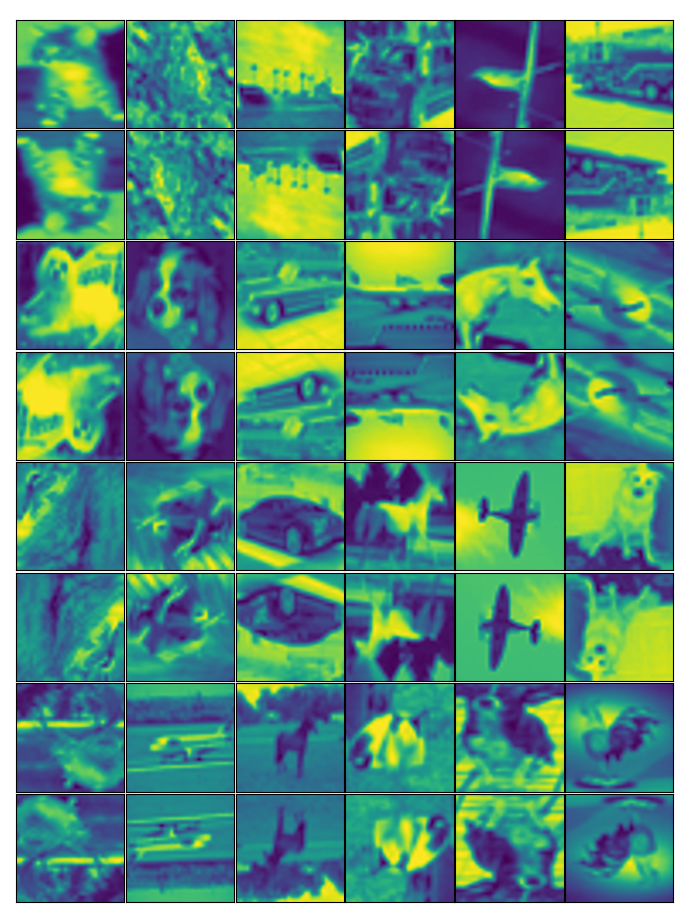

In [10]:
data_cols = 6
data_rows = 4
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

for (image, image_), (col,row) in zip(dataset.train, product(range(data_cols),range(data_rows))):
    axes = plot.axes.add(col,2*row)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(image[0].squeeze().abs(), aspect='auto')


    axes = plot.axes.add(col,2*row+1)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(image_[0].squeeze().abs(), aspect='auto')
plot.show()

# Обучение модели

In [11]:
models_history, loss_histories, confusion_matrices_history = [], [], []

In [12]:
torch.cuda.empty_cache()

In [ ]:
SelectedGPUs.exclude(0,7)
mh, lh, cmh = epochs(10, 10, optical_incoherent, dataset, ImageComparisonMSE(normilize=True), optimizer_type, lr=0.003)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 116529
Training thread#0 PID is: 116748
Training thread#1 PID is: 116857
Training thread#2 PID is: 117092
Training thread#3 PID is: 117330
Training thread#4 PID is: 117529
Training thread#5 PID is: 117728
RL:73.571·10⁻³, RPI1K:-15.66·10⁻³: 100%|██████████ | 1191/1191 | 39:45m - 00:00m
Mean loss after epoch 1 is 0.0787313239700548
RL:59.203·10⁻³, RPI1K:-12.53·10⁻³: 100%|██████████ | 1191/1191 | 39:38m - 00:00m
Mean loss after epoch 2 is 0.06591471729410686
RL:48.754·10⁻³, RPI1K:-7.85·10⁻³:  65%|███████▊     | 771/1191 | 25:50m - 13:44m

# Визуализация

In [ ]:
with torch.no_grad():
    model = models_history[-1].to(device)
    
    ratio = 0.3
    images = []
    dataset = Dataset('STL10', 1, N, N, torch.complex64, threads=1, preload=10)
    dataset.padding(surface_ratio=ratio)
    images.append(next(iter(dataset.test))[0])
    dataset = Dataset('CIFAR10', 1, N, N, torch.complex64, threads=1, preload=10)
    dataset.padding(surface_ratio=ratio)
    images.append(next(iter(dataset.test))[0])
    dataset = Dataset('MNIST', 1, N, N, torch.complex64, threads=1, preload=10)
    dataset.padding(surface_ratio=ratio)
    images.append(next(iter(dataset.test))[0])
    temp = interpolate(torch.mean(torchvision.transforms.functional.pil_to_tensor(Image.open('../../figures/MSU.jpg')).to(torch.float32), dim=0).unsqueeze(0).unsqueeze(0), (N,N))
    images.append(temp)
    labels = ['STL10', 'CIFAR10', 'MNIST', 'Высокое разрешение']
    
    plot = TiledPlot(*FigureWidthHeight)
    plot.FontLibrary = FontLibrary
    plot.description.column.top('Исходное изображение', 0)
    plot.description.column.top('Полученное изображение', 1)
    
    for row, (image, label) in enumerate(zip(images, labels)):
        plot.description.row.left(label, row)
        
        image = image.to(device)
        result = model.forward(image)
        image, result = image.clone().detach().squeeze().abs().cpu(), result.clone().detach().squeeze().abs().cpu()

        axes = plot.axes.add(0, row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow(image, aspect='auto')

        axes = plot.axes.add(1,row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow(result, aspect='auto')
    
    plot.show()

In [ ]:
import matplotlib.pyplot as plt

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

plot.title("Фазовая маска")

axes = plot.axes.add((0,0),(4,5))
# axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
image = axes.imshow(models_history[-1].element(2).multiplier().angle().squeeze(), aspect='auto')
axes_ = plot.axes.add((5,0),(5,5))
bar = plt.colorbar(image, cax=axes_, shrink=0.7, format=lambda x,i: f"{round(x/3.1415,1)}$\pi$", location='right')

plot.show()

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.width_to_height(2.0)
plot.title("Зависимость ошибки от номера итерации")

# loss_history = numpy.concatenate(loss_histories)
axes = plot.axes.add(0,0)
axes.grid(True)

axes_ = plot.axes.add(0,1)
axes_.grid(True)

start = 0
for i, loss_history in enumerate(loss_histories): 
    axes.plot(numpy.arange(start, start + len(loss_history)), loss_history)
    axes_.plot(loss_history)
    start += len(loss_history)
    
plot.show()